In [1]:
!rm -rf /kaggle/working/
!git clone https://github.com/svenspa/FML.git

rm: cannot remove '/kaggle/working/': Device or resource busy
Cloning into 'FML'...
remote: Enumerating objects: 479, done.
remote: Counting objects: 100% (479/479), done.
remote: Compressing objects: 100% (334/334), done.
remote: Total 479 (delta 225), reused 369 (delta 133), pack-reused 0
Receiving objects: 100% (479/479), 1.31 MiB | 1.49 MiB/s, done.
Resolving deltas: 100% (225/225), done.


In [2]:
import os
origin_path = "/kaggle/working"
fml_path = "/kaggle/working/FML"

In [3]:
!pip install arch
!pip install yfinance
!pip install fastparquet

     |████████████████████████████████| 902 kB 295 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=538a88e7cb7a210427d26a70b8dbcbd9066e58bef83622e5e403ec135844f6ee
  Stored in directory: /root/.cache/pip/wheels/34/ba/79/c0260c6f1a03f420ec7673eff9981778f293b9107974679e36
Successfully built multitasking
     |████████████████████████████████| 1.2 MB 291 kB/s            
     |████████████████████████████████| 59 kB 4.8 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 1.6 MB 17.5 MB/s            
  Created wheel for thrift: filename=thrift-0.15.0-cp37-cp37m-linux_x86_64.whl size=413817 sha256=e8a54739ebe298cd1562a06ed4648e3d6c69d0c2929e1b6262628ee01fb7e1b5
  Stored in directory: /root/.cache/pip/wheels/ba/1f/8e/e6fd36837eecf3d1f2b23f1729477e8e06558d8d60b7093f51
Successfully built thrift


In [4]:
os.chdir(fml_path)

In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import yfinance as yf

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

from data import DataGJR, DataRes
from market_dynamics import bs_call_price
from models import ControlNet, EnsembleNet
from train import train_val
from risk_measures import median_loss
from utils import call_payoff, stochastic_integral


In [6]:
GJR_FOLDER = "../input/gjr-vol/v2_2/v2/"
RES_FOLDER = "../input/gjr-vol/ressim/resssim/"

In [7]:
os.chdir(origin_path)

## Data

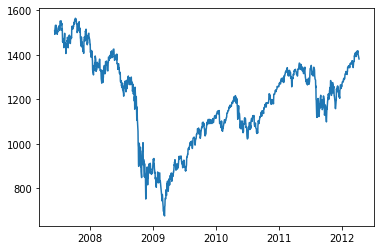

In [8]:
ticker = yf.Ticker('^GSPC')
hist = ticker.history(start='2007-06-11', end='2012-04-10').Close
plt.plot(hist);

In [9]:
# From fitting the GARCH model using R get following parameters

SIGMA = 0.1221684
MU = 0.056105

SQRT_252 = 252 ** 0.5

In [10]:
h_params = {"N_SIM": 4000,
            "RF": 0,
            "N_DIMS": 2,
            "FC_DIM": 20,
            "LR": 0.005,
            "GAMMA": 0.96,
            "EPOCHS": 10,
            "BATCH_SIZE": 256,}

In [11]:
initial_value = hist.iloc[0]
strike = initial_value
n_steps = 30
price = bs_call_price(n_steps, initial_value, SIGMA, h_params["RF"], strike)
initial_value, strike, SIGMA, price

(1509.1199951171875, 1509.1199951171875, 0.1221684, 21.0855397479188)

In [12]:
dt = DataGJR(GJR_FOLDER, price, call_payoff, {"strike": strike}, splits=h_params["N_SIM"], S0=initial_value, sigma_0=SIGMA, mu_const=MU, take_log=True, vol_feature=False)
res_dt = DataRes(RES_FOLDER, price, call_payoff, {"strike": strike}, splits=100, S0=initial_value, take_log=True)

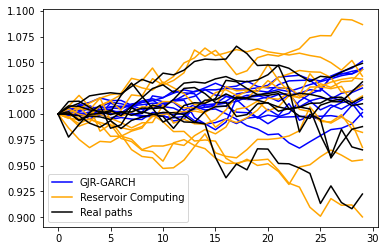

In [13]:
gjr_x, _, _, _, = dt[1]
res_x, _, _, _, = res_dt[1]
gjr_x, res_x = torch.exp(gjr_x), torch.exp(res_x)

gjr_example_paths = gjr_x[:10]
res_example_paths= res_x[:10]

fut = ticker.history(start='2018-01-02', end='2019-01-02').Close
m = np.floor(len(fut) / n_steps)
real_example_paths = []

for i in np.arange(start=0, stop=(m-1)*n_steps, step=n_steps):
    i = int(i)
    path = fut.iloc[i:i+n_steps].values
    path = path / path[0]
    real_example_paths.append(path)

plt.plot(gjr_example_paths.T.squeeze(), c='blue');
plt.plot(res_example_paths.T.squeeze(), c='orange');
plt.plot(np.array(real_example_paths).T, c='black');

# plt.legend(['GJR-GARCH', 'Reservoir Computing', 'Real paths'])
gjrpath_leg = Line2D([0], [0], color='blue', label='GJR-GARCH')
rc_leg = Line2D([0], [0], color='orange', label='Reservoir Computing')
real_leg = Line2D([0], [0], color='black', label='Real paths')
plt.legend(handles=[gjrpath_leg, rc_leg, real_leg])

plt.savefig('compare_paths.eps', format='eps')

plt.show()

In [14]:
gjr, res = [], []

for i in np.arange(1, 100):
    gjr_x, _, _, _, = dt[i]
    res_x, _, _, _, = res_dt[i]
    gjr.append(gjr_x)
    res.append(res_x)

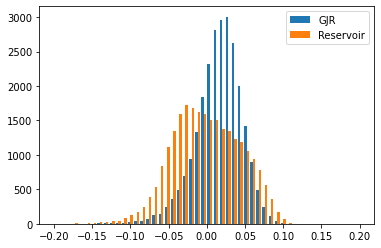

In [15]:
h1 = torch.cat(gjr).squeeze()[:, -1].numpy()
h2 = torch.cat(res).squeeze()[:, -1].numpy()
plt.hist([h1, h2], bins=50, label=["GJR", "Reservoir"], range=(-0.2, 0.2))
plt.legend();
plt.savefig("marketfinaldistribution.eps")